#### Etape 1 : Importer les librairies nécessaires pour notre modèle CNN

In [15]:
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , TensorBoard
from tensorflow.keras.applications import VGG16

import numpy as np
import matplotlib.pyplot as plt

import pathlib
from pathlib import Path
import os

import imghdr
from PIL import Image
import cv2 

import itertools
import datetime

#### Etape 2 : Préparer l'envirronement de travail (activer l'accélération GPU)

In [16]:
def prepare_gpu_acceleration():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print("GPU is AVAILABLE 🚀")
        print(tf.config.experimental.list_physical_devices('GPU'))
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
        except RuntimeError as e:
            print("An error occured while setting memory growth for GPU 💀")
            print(e)
    else:
        print("GPU is NOT AVAILABLE 🐌")
        print(tf.config.experimental.list_physical_devices())

prepare_gpu_acceleration()

GPU is AVAILABLE 🚀
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Etape 3 : Préparer les données d'entrainement et de test

In [17]:
# Initialiser les paramètres du modèle
RESCALING_FACTOR = 1./255
ROTAION_RANGE = 20, 
WIDTH_SHIFT_RANGE = 0.2
HEIGHT_SHIFT_RANGE = 0.2
SHEAR_RANGE = 0.2
ZOOM_RANGE = 0.2
HORIZONTAL_FLIP = True
VALIDATION_SPLIT = 0.2

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_CHANNELS = 3
BACH_SIZE = 32

AUTOTUNE_SHUFFLE_BUFFER_SIZE = 1000

CLASS_MODE = "categorical"
LOSS_FUNCTION = "categorical_crossentropy"
LEARING_RATE = 0.001
METRICS = ["accuracy"]
EPOCHS = 15

In [18]:
# Définir les chemins vers les données
data_dir = 'data'

# creer les générateurs d'images
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2 # 80% training and 20% validation
)


In [19]:
# Preparer les données d'entrainement et de validation
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# Preparer les données de validation
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 15990 images belonging to 2 classes.
Found 3996 images belonging to 2 classes.


#### Etape 4 : Charger le modèle pré-entrainé

In [20]:
# https://keras.io/api/applications/vgg/#vgg16-function
# VGG16 est un modèle pré-entrainé sur le jeu de données ImageNet, qui contient 1000 classes, dont les images sont de taille 224x224 pixels

# charger le modèle VGG16 pré-entrainé
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

In [21]:
# Congeler les couches du modèle VGG16
vgg.trainable = False

In [22]:
# Résumé de l'architecture du modèle VGG16
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Etape 5 : Créer le modèle CNN

In [23]:
# Identifier les classes 
class_names = train_generator.class_indices
num_classes = len(class_names)
print(f"Total de classes ({num_classes}) - {class_names}")

Total de classes (2) - {'Painting': 0, 'Photo': 1}


In [24]:
# Creation du modéle de CNN
model = Sequential()

In [25]:
# Ajouter le modèle VGG16 pré-entrainé
model.add(vgg)

# Applatissement des couches
model.add(Flatten())

# Ajouter une couche dense de 128 neurones
model.add(Dense(128, activation='relu'))

# Ajouter une couche de dropout
model.add(Dropout(0.2))

# Ajouter une couche de sortie
model.add(Dense(num_classes, activation='softmax'))

In [26]:
# résumer le modéle
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 128)               3211392   
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 258       
                                                                 
Total params: 17,926,338
Trainable params: 3,211,650
Non-trainable params: 14,714,688
_________________________________________________________________


#### Etape 6 : Compilation et entrainement du modèle

In [27]:
# Compiler le modéle
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

In [28]:
model_filepath = f"models/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}/model.h5"
logs_dir = f"logs/{datetime.datetime.now().strftime('%Y%m%d-%H%M%S')}"
# Définir les callbacks pour l'entrainement
callbacks = [
    # Définition de l'arret précoce pour éviter le sur-apprentissage
    EarlyStopping(
        monitor='val_loss', 
        patience=3
    ),
    # Validation croisée
    ModelCheckpoint(
        filepath=model_filepath,
        monitor='val_loss', 
        save_best_only=True
    ),
    # TensorBoard pour visualiser les courbes d'apprentissage
    TensorBoard(log_dir=logs_dir, histogram_freq=1)
]


In [29]:
# Entrainement du modéle
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    verbose=1,
    callbacks=callbacks
)

Epoch 1/30
500/500 [==============================] - 411s 802ms/step - loss: 0.4122 - accuracy: 0.8242 - val_loss: 0.2814 - val_accuracy: 0.8824
Epoch 2/30
500/500 [==============================] - 387s 773ms/step - loss: 0.3145 - accuracy: 0.8672 - val_loss: 0.2610 - val_accuracy: 0.8959
Epoch 3/30
500/500 [==============================] - 400s 800ms/step - loss: 0.2870 - accuracy: 0.8822 - val_loss: 0.2769 - val_accuracy: 0.8831
Epoch 4/30
500/500 [==============================] - 374s 748ms/step - loss: 0.2761 - accuracy: 0.8893 - val_loss: 0.2365 - val_accuracy: 0.8999
Epoch 5/30
500/500 [==============================] - 370s 740ms/step - loss: 0.2633 - accuracy: 0.8919 - val_loss: 0.2331 - val_accuracy: 0.9064
Epoch 6/30
500/500 [==============================] - 362s 724ms/step - loss: 0.2573 - accuracy: 0.8961 - val_loss: 0.2296 - val_accuracy: 0.9077
Epoch 7/30
500/500 [==============================] - 1038s 2s/step - loss: 0.2478 - accuracy: 0.8989 - val_loss: 0.2221 - v

#### Etape 7 : Evaluation du modèle

In [30]:
# Récupérer les données de l'historique
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

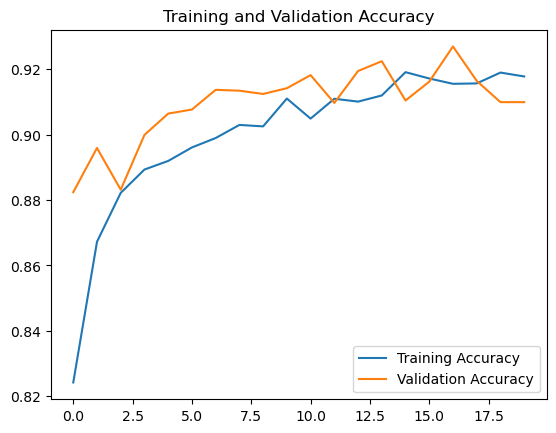

In [31]:
# Afficher les courbes de précision
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

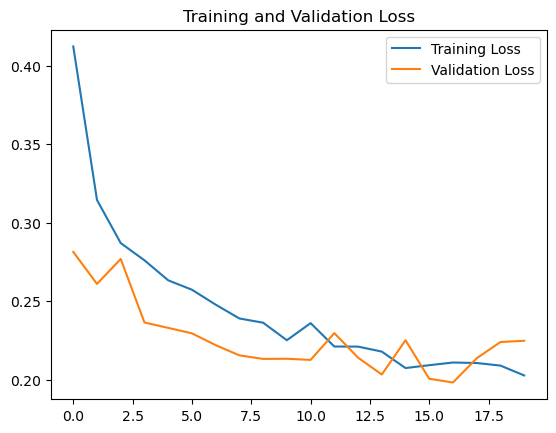

In [32]:
# Afficher les courbes de perte
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [33]:
def overfitting_underfitting(acc , val_acc , loss , val_loss):
   if acc[-1] > val_acc[-1] and loss[-1] < val_loss[-1]:
      print("The model is overfitting 🤮")
      print(f"Training accuracy : {acc[-1]*100:.2f}%")
      print(f"Validation accuracy : {val_acc[-1]*100:.2f}%")
   elif acc[-1] < val_acc[-1] and loss[-1] > val_loss[-1]: 
      print("The model is underfitting 🗿")
      print(f"Training accuracy : {acc[-1]*100:.2f}%")
      print(f"Validation accuracy : {val_acc[-1]*100:.2f}%")
   else:
      print("The model is perfect fit 🧠")
      print(f"Training accuracy : {acc[-1]*100:.2f}%")
      print(f"Validation accuracy : {val_acc[-1]*100:.2f}%")
      
overfitting_underfitting(acc , val_acc , loss , val_loss)

The model is overfitting 🤮
Training accuracy : 91.78%
Validation accuracy : 90.99%


In [ ]:
# Congeler les couches du modèle VGG16
vgg.trainable = True

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Nombre de couches dans le model MobileNet: ", len(vgg.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001/10),
    metrics=['accuracy']
)

In [ ]:
model.summary()

In [ ]:
hist_fine = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    initial_epoch=history.epoch[-1],
    verbose=1,
    callbacks=callbacks
)

In [ ]:
acc += hist_fine.history['accuracy']
val_acc += hist_fine.history['val_accuracy']

loss += hist_fine.history['loss']
val_loss += hist_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([30-1,30-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([30-1,30-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()